# OpenScope's Global/Local Oddball Dataset
Current state of knowledge in the field: The brain rapidly adapts to unchanging environments, and is most excited by surprising events. A leading model to explain this phenomenon is predictive coding. Predictive coding proposes that the brain compares incoming sensory information against a prediction signal. This prediction is based on an internal model that is generated in higher-order cortex. This model reflects the brain’s assumptions about the statistics of the environment. If an incoming sensory signal matches the prediction, the two signals cancel. Expected sensory data thus are “explained away” and leave the brain unexcited. In other words, predictive coding is subtractive. The prediction signal inhibits the processing of sensory data.

Whenever the sensory signal does not match the prediction, subtraction results in a larger value, called the prediction error. This error signal initiates excitation in lower-order cortex that propagates feedforward up the cortical hierarchy (i.e., V1, RL, LM, AL, PM, and AM). Prediction errors then instigate updates to the internal model to improve future predictions. Associated prediction update signals flow back down the hierarchy. Consistent with this model, optogenetic silencing of top-down inputs from frontal to visual cortex largely eliminates prediction error signals. However, the precise circuit mechanisms that generate these signals are largely unknown. The GLO projects aims close this knowledge gap. Specifically, by recording from multiple neuropixels across the visual cortical hierarchy, we will uncover what information is carried by layer 2 and 3 spikes that feed forward vs. by layer 5 and 6 spikes that feed back, using recently established analytic tools. To fully understand the involved neural mechanisms, we propose to go further: It is now possible to measure specific populations of inhibitory interneurons in tasks manipulating stimulus predictability using two-photon Calcium imaging. This technique revealed distinct computations for somatostatin (SOM+) vs. parvalbumin (PV+) interneurons in mice exposed to the same repeated (and thus predictable) stimulus. As stimuli became increasingly predictable, PV+ interneurons became less active while SOM+ interneurons became more active. Thus, the subtraction between predicted stimuli and sensory data seems to be mediated by SOM+ interneurons. This observation also implies that PV+ interneurons might be involved in the generation of prediction errors. However, this work relied on stimulus repetitions across several days, thus lacking insight into the dynamics on a more behaviorally relevant scale.

Lastly, the project aims to answer one of the most vexing paradigmatic questions of predictive coding: Significant progress in our understanding of the neural machinery underlying predictive coding stems from so-called oddball tasks. Specifically, by differentiating between so-called local (1st order) vs. global (2nd order) oddballs, researchers successfully dissociated automatic mechanisms of prediction from context-driven forms of predictive processing (Fig. 3). Cortical responses to local oddballs occur reflexively, even under deep anesthesia. Cortical responses to global oddballs require integration of stimuli across time to form complex predictions and are absent during unconsciousness. However, little is known about the neural circuitry supporting these two types of prediction errors. As we lay out below, the multi-area laminar spiking data combined with optogenetic cell type characterization (optotagging) of the Allen Institute can close this gap. Using this combination, we will specify the laminar sources, inhibitory cell types, and directions of neural signal flow (feedforward/feedback) that mediate these computations.

![glo_fig3.png](../../data/images/glo_fig3.png)

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [1]:
import warnings
warnings.filterwarnings('ignore')

try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .
    %cd docs/projects

In [2]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import floor, ceil, isclose
from PIL import Image

### Downloading Ecephys File

In [3]:
dandiset_id = "001191"
# dandi_filepath = "sub-747815/sub-747815_ses-2024+08+28_ecephys.nwb"
dandi_filepath = "sub-747816/sub-747816_ses-2024+08+14_ecephys.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [4]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.67.0) of dandi/dandi-cli is available. You are using 0.61.2


File already exists
Opening file


### Extracting Units Spikes
Below, the `Units` table is retrieved from the file. It contains many metrics for every putative neuronal unit, printed below. For the analysis in this notebook, we are only interested in the `spike_times` attribute. This is an array of timestamps that a spike is measured for each unit. For more information on the various unit metrics, see [Visualizing Unit Quality Metrics](../visualization/visualize_unit_metrics.ipynb). From this table, the Units used in this notebook are selected if they have 'good' quality rather than 'noise', and if they belong in one of the regions of the primary visual cortex.

In [5]:
units = nwb.units
units[:10]

,spike_times,electrodes,waveform_mean,waveform_sd,unit_name,nn_hit_rate,sliding_rp_violation,sync_spike_8,amplitude_cv_range,firing_rate,...,half_width,num_negative_peaks,peak_to_valley,device_name,presence_ratio,decoder_probability,num_spikes,isi_violations_count,estimated_x,ks_unit_id
id,,,,,,,,,,,,,,,,,,,,,
0,"[0.09196666666666667, 0.8493, 0.93166666666666...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-1.5490809679031372, -3.1777184009552, -0.71...","[[20.574935913085938, 22.251150131225586, 20.0...",208b60b0-c92a-4a2c-8aec-7c73ad03986b,0.327333,0.130,0,NaN,2.364103,...,0.000173,1,0.000253,probeA,1.000000,0.73,17707,16,58.16,0
1,"[0.4660666666666667, 0.7403333333333333, 1.820...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-1.7316008806228638, -0.9593998193740845, -3...","[[20.527618408203125, 20.86381721496582, 18.70...",777fb49e-0d40-42ca-91c2-b6179a5ee943,0.644000,0.045,0,NaN,0.955548,...,0.000177,1,0.000347,probeA,0.572581,0.84,7157,0,-17.24,1
2,"[3.733433333333333, 3.7469, 6.383633333333333,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.912600040435791, -1.8626396656036377, -1....","[[17.01324462890625, 17.12687873840332, 16.185...",b0d517b2-30b6-4189-848f-f15b077a5a4c,0.824000,NaN,0,NaN,0.261017,...,0.000167,1,0.000390,probeA,0.588710,0.70,1955,0,11.25,2
3,"[0.0231, 0.26616666666666666, 0.32906666666666...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.2854800224304199, -0.07488039135932922, 0...","[[17.980432510375977, 17.647844314575195, 17.1...",23b97547-43ff-4f70-af31-a16cae398c68,0.810000,0.110,0,0.154504,3.460640,...,0.000143,1,0.000283,probeA,1.000000,0.71,25920,28,31.27,3
4,"[0.012133333333333333, 0.04806666666666667, 0....","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.0982801541686058, -0.9172800183296204, 0....","[[16.0756893157959, 17.466861724853516, 17.162...",73b8c50c-5b01-4259-8af8-c2f4940d164e,0.910667,0.020,0,NaN,4.983616,...,0.000387,1,0.001523,probeA,0.532258,0.51,37327,7,43.59,5
5,"[0.26056666666666667, 0.36866666666666664, 0.5...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[-0.19187967479228973, -0.3931201696395874, -...","[[18.781797409057617, 18.820898056030273, 18.3...",c93159d2-41e3-4f6e-a63e-8c6b89589ed2,0.927333,NaN,0,NaN,0.220562,...,0.000107,1,0.000200,probeA,0.774194,0.53,1652,0,34.68,6
6,"[2.183133333333333, 2.2282333333333333, 2.3920...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0.0, 0.0, 0.0, 0.0, 1.0202398300170898, 0.72...","[[0.0, 0.0, 0.0, 0.0, 18.395723342895508, 17.1...",e6353dab-b00f-40e7-8182-c70c2b2d3a5a,0.557333,0.235,0,NaN,0.512420,...,0.000110,1,0.000200,probeA,0.733871,0.72,3838,0,31.90,8
7,"[0.0097, 0.017333333333333333, 0.0721333333333...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",871f0ddf-d2c1-4b01-be13-5aaf164b1623,0.986667,0.005,0,0.069786,33.256594,...,0.000123,1,0.000283,probeA,1.000000,0.74,249090,3,22.61,9
8,"[1.1408666666666667, 2.5382666666666664, 2.635...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",231bd337-d5a1-472b-9b81-3f4791ffcec4,0.981333,0.030,0,NaN,2.065837,...,0.000133,1,0.000167,probeA,1.000000,0.63,15473,1,3.09,10


In [6]:
# # select electrodes
# channel_probes = {}

# electrodes = nwb.electrodes
# for i in range(len(electrodes)):
#     channel_id = electrodes["id"][i]
#     location = electrodes["location"][i]
#     channel_probes[channel_id] = location

# # function aligns location information from electrodes table with channel id from the units table
# def get_unit_location(row):
#     return channel_probes[int(row.peak_channel_id)]

# print(set(get_unit_location(row) for row in units))

In [7]:
# ### selecting units spike times

# brain_regions = ["VISp6a", "VISp5", "VISp4", "VISp6b", "VISp2/3"]

# # select units based if they have 'good' quality and exists in one of the specified brain_regions
# units_spike_times = []
# for location in brain_regions:
#     location_units_spike_times = []
#     for row in units:
#         if get_unit_location(row) == location and row.quality.item() == "good":
#             location_units_spike_times.append(row.spike_times.item())
#     units_spike_times += location_units_spike_times

# print(len(units_spike_times))

In [8]:
# select units based if they have 'good' quality and exists in one of the specified brain_regions
units_spike_times = []
for row in units:
    if row.snr.item() > 10 and row.isi_violations_ratio.item() < 5:
        units_spike_times.append(row.spike_times.item())

print(len(units_spike_times))

744


### Extracting Stimulus Times

In [9]:
nwb.intervals.keys()

dict_keys(['create_receptive_field_mapping_presentations', 'movie00_presentations', 'movie01_presentations', 'movie02_presentations', 'movie03_presentations', 'movie04_presentations', 'movie05_presentations', 'movie06_presentations', 'movie07_presentations', 'movie08_presentations', 'movie09_presentations', 'movie10_presentations', 'movie11_presentations', 'movie12_presentations', 'movie13_presentations', 'movie14_presentations', 'movie15_presentations', 'movie16_presentations', 'movie17_presentations', 'movie18_presentations', 'movie19_presentations', 'movie20_presentations', 'movie21_presentations', 'movie22_presentations', 'movie23_presentations', 'movie24_presentations', 'movie25_presentations', 'movie26_presentations', 'movie27_presentations', 'movie28_presentations', 'movie29_presentations', 'movie30_presentations', 'movie31_presentations', 'movie32_presentations', 'movie33_presentations', 'movie34_presentations', 'movie35_presentations', 'movie36_presentations', 'movie37_present

0.048485597103886585


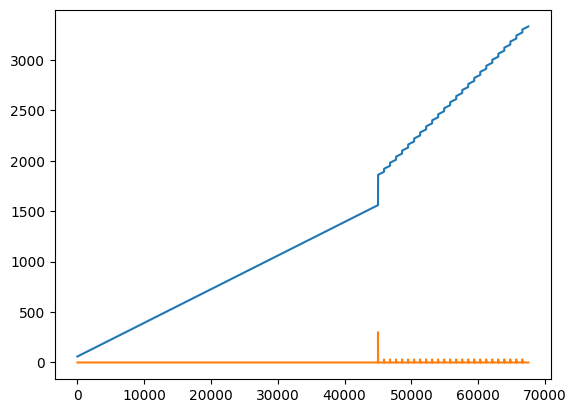

In [10]:
stim_table = nwb.intervals["movie01_presentations"]
print(np.mean(np.diff(stim_table.start_time)))
plt.plot(stim_table.start_time)
plt.plot(np.diff(stim_table.start_time))

In [11]:
stim_table[:10]

,start_time,stop_time,stim_name,stim_type,stim_block,frame,stim_index,tags,timeseries
id,,,,,,,,,
0,59.198227,59.231592,movie01,ImageStimNumpyuByte,0.0,0.0,1.0,[stimulus_time_interval],"[(0, 1, timestamps pynwb.base.TimeSeries at 0x..."
1,59.231592,59.264957,movie01,ImageStimNumpyuByte,0.0,1.0,1.0,[stimulus_time_interval],"[(1, 1, timestamps pynwb.base.TimeSeries at 0x..."
2,59.264957,59.298322,movie01,ImageStimNumpyuByte,0.0,2.0,1.0,[stimulus_time_interval],"[(2, 1, timestamps pynwb.base.TimeSeries at 0x..."
3,59.298322,59.331688,movie01,ImageStimNumpyuByte,0.0,3.0,1.0,[stimulus_time_interval],"[(3, 1, timestamps pynwb.base.TimeSeries at 0x..."
4,59.331688,59.365053,movie01,ImageStimNumpyuByte,0.0,4.0,1.0,[stimulus_time_interval],"[(4, 1, timestamps pynwb.base.TimeSeries at 0x..."
5,59.365053,59.398418,movie01,ImageStimNumpyuByte,0.0,5.0,1.0,[stimulus_time_interval],"[(5, 1, timestamps pynwb.base.TimeSeries at 0x..."
6,59.398418,59.431783,movie01,ImageStimNumpyuByte,0.0,6.0,1.0,[stimulus_time_interval],"[(6, 1, timestamps pynwb.base.TimeSeries at 0x..."
7,59.431783,59.465149,movie01,ImageStimNumpyuByte,0.0,7.0,1.0,[stimulus_time_interval],"[(7, 1, timestamps pynwb.base.TimeSeries at 0x..."
8,59.465149,59.498514,movie01,ImageStimNumpyuByte,0.0,8.0,1.0,[stimulus_time_interval],"[(8, 1, timestamps pynwb.base.TimeSeries at 0x..."


In [12]:
stim_times_1 = [row['start_time'].item() for row in nwb.intervals['movie01_presentations'] if row.frame.item() == '0.0']
print(len(stim_times_1))

75


In [13]:
table = pd.read_csv(r"C:\Users\carter.peene\Desktop\loop\new_1386590577_stim_table.csv")
stim_times_2 = [row[1]['start_time'] for row in table.iterrows() if row[1]['frame'] == 0.0 and row[1]['stim_name'] == 'movie01']
print(len(stim_times_2))

75


In [14]:
stim_times = stim_times_1

### Generating Spike Matrix

In [15]:
# bin size for counting spikes
time_resolution = 0.1

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = 0
window_end_time = 30

In [16]:
def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    time_resolution = np.mean(np.diff(bin_edges))
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((len(units_spike_times), len(stim_times), len(bin_edges)-1))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in range(len(units_spike_times)):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, stim_idx, bin_idx] += 1

    return spike_matrix

In [17]:
# time bins used
n_bins = int((window_end_time - window_start_time) / time_resolution)
bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

# calculate baseline and stimulus interval indices for use later
stimulus_onset_idx = int(-bin_edges[0] / time_resolution)

spike_matrix = get_spike_matrix(stim_times, units_spike_times, bin_edges)

print(spike_matrix.shape)

(744, 75, 299)


### Showing Response Windows
After generating spike matrices, we can view the PSTHs for each unit.

In [18]:
def show_response(ax, window, window_start_time, window_end_time, aspect="auto", vmin=None, vmax=None, yticklabels=[], skipticks=1, xlabel="Time (s)", ylabel="ROI", cbar=True, cbar_label=None):
    if len(window) == 0:
        print("Input data has length 0; Nothing to display")
        return

    img = ax.imshow(window, aspect=aspect, extent=[window_start_time, window_end_time, 0, len(window)], interpolation="none", vmin=vmin, vmax=vmax)
    if cbar:
        ax.colorbar(img, shrink=0.5, label=cbar_label)

    ax.plot([0,0],[0, len(window)], ":", color="white", linewidth=1.0)

    if len(yticklabels) != 0:
        ax.set_yticks(range(len(yticklabels)))
        ax.set_yticklabels(yticklabels, fontsize=8)

        n_ticks = len(yticklabels[::skipticks])
        ax.yaxis.set_major_locator(plt.MaxNLocator(n_ticks))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [19]:
def show_many_responses(windows, rows, cols, window_idxs=None, title=None, subplot_title="", xlabel=None, ylabel=None, cbar_label=None, vmin=0, vmax=2):
    if window_idxs is None:
        window_idxs = range(len(windows))
    windows = windows[window_idxs]
    
    # handle case with no input data
    if len(windows) == 0:
        print("Input data has length 0; Nothing to display")
        return
    # handle cases when there aren't enough windows for number of rows
    if len(windows) < rows*cols:
        rows = (len(windows) // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols, 3*rows), layout="constrained")
    # handle case when there's only one row
    if len(axes.shape) == 1:
        axes = axes.reshape((1, axes.shape[0]))

    for i in range(rows*cols):
        ax_row = int(i // cols)
        ax_col = i % cols
        ax = axes[ax_row][ax_col]
        
        if i > len(windows)-1:
            ax.set_visible(False)
            continue

        window = windows[i]
        show_response(ax, window, window_start_time, window_end_time, xlabel=xlabel, ylabel=ylabel, cbar=False, vmin=vmin, vmax=vmax)
        ax.set_title(f"{subplot_title} {window_idxs[i]}")
        if ax_row != rows-1:
            ax.get_xaxis().set_visible(False)
        if ax_col != 0:
            ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=axes, shrink=2/cols, label=cbar_label)


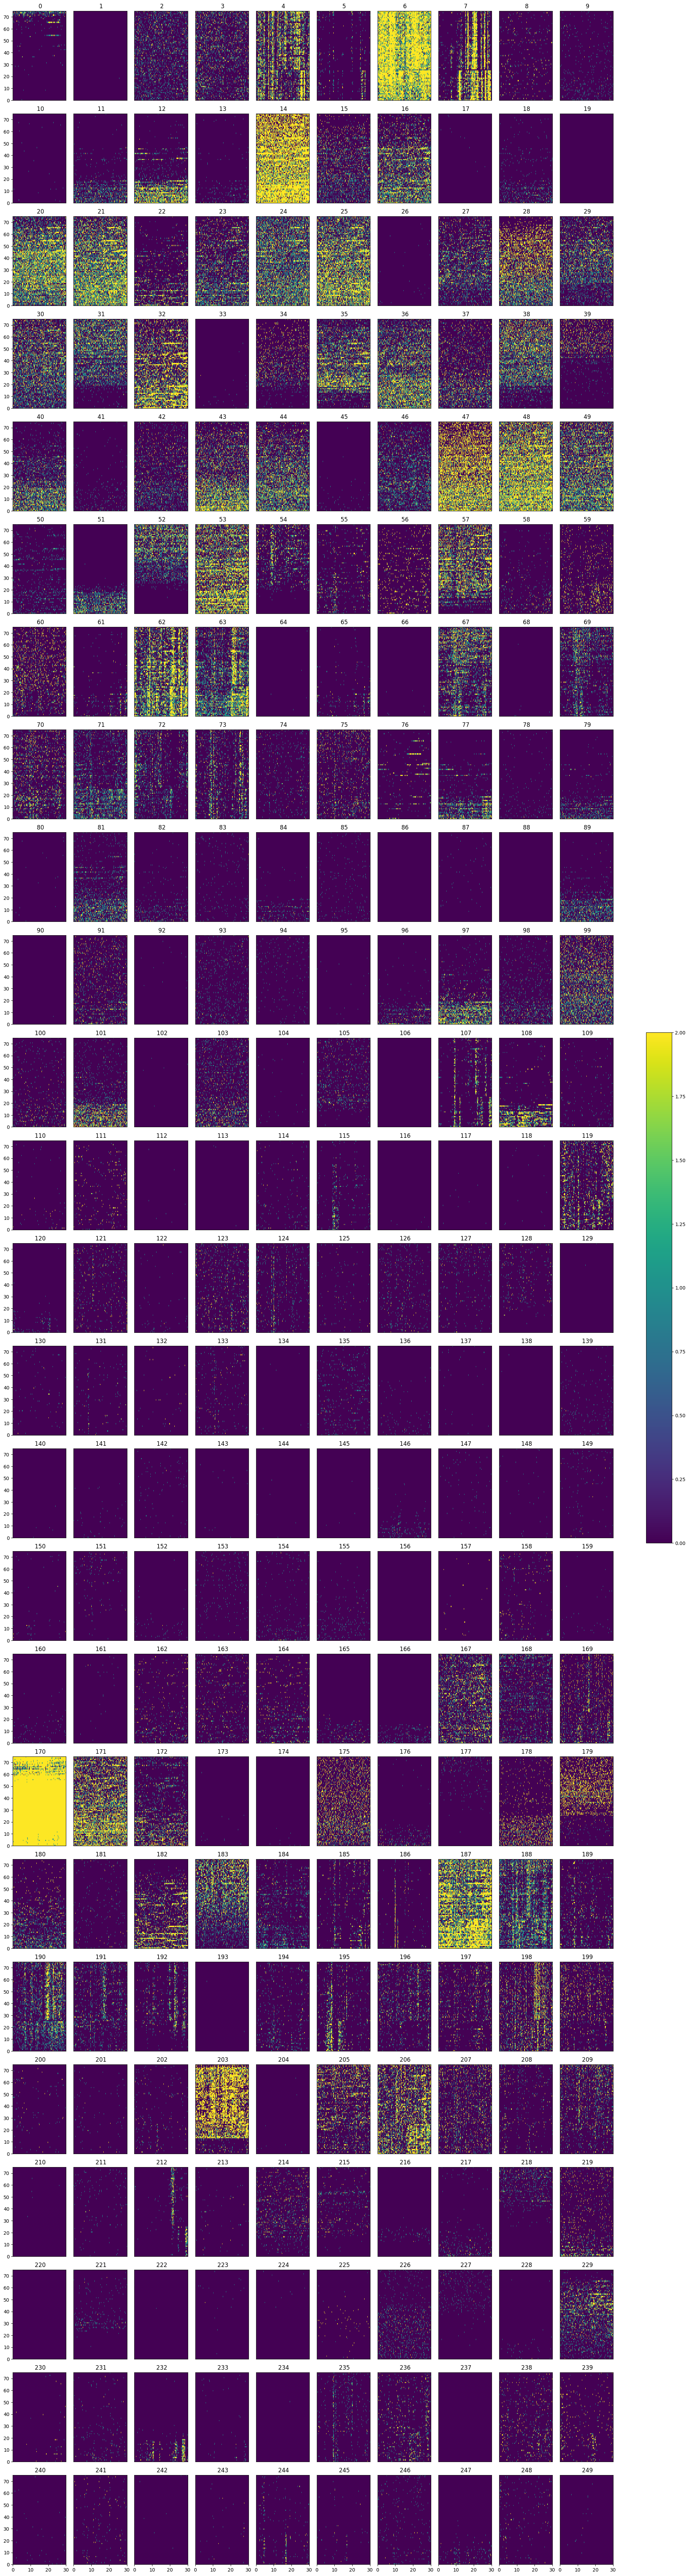

In [20]:
show_many_responses(spike_matrix, 25, 10)